In [1]:
%load_ext autoreload
%autoreload 2

import os, sys, json, time, warnings
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

/home/pduce/ICAIF_2025_Cryptocurrency_Forecasting_Starter_Kit/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Paths (adjust if your layout differs)
ROOT = Path('/home/pduce/ICAIF_2025_Cryptocurrency_Forecasting_Starter_Kit')
DATA = ROOT / "data"
SRC  = ROOT / "src"
SUBM = ROOT / "sample_submission"

# Ensure src is importable
if str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))

# Create sample_submission dir if missing
SUBM.mkdir(parents=True, exist_ok=True)

SEED = 1337
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [3]:
# Load dataset files
info_path = DATA / "dataset_info.json"
if info_path.exists():
    info = json.loads(info_path.read_text(encoding="utf-8"))
    print("dataset_info.json loaded. Keys:", list(info.keys()))
    print(json.dumps({k: info[k] for k in ['features','input_len','horizon_len','outputs']}, indent=2))
else:
    print("dataset_info.json not found at", info_path)

# Peek train / x_test
train_path = DATA / "train.pkl"
x_test_path  = DATA / "x_test.pkl"
y_local_path = DATA / "y_test_local.pkl"

train = pd.read_pickle(train_path)
x_test  = pd.read_pickle(x_test_path)
y_test_local = pd.read_pickle(y_local_path)

print("train shape:", train.shape, "| columns:", train.columns.tolist())
print("x_test  shape:", x_test.shape,  "| columns:", x_test.columns.tolist())
print("y_test_local shape:", y_test_local.shape, "| columns:", y_test_local.columns.tolist())

display(train.head(3))
display(x_test.head(3))
display(y_test_local.head(3))

dataset_info.json loaded. Keys: ['freq', 'features', 'input_len', 'horizon_len', 'dtypes', 'outputs', 'sha256']
{
  "features": [
    "close",
    "volume"
  ],
  "input_len": 60,
  "horizon_len": 10,
  "outputs": {
    "train": {
      "columns": [
        "series_id",
        "time_step",
        "close",
        "volume"
      ]
    },
    "x_test": {
      "columns": [
        "window_id",
        "time_step",
        "close",
        "volume"
      ]
    },
    "y_test_local": {
      "columns": [
        "window_id",
        "time_step",
        "close"
      ]
    }
  }
}
train shape: (18331224, 4) | columns: ['series_id', 'time_step', 'close', 'volume']
x_test  shape: (3000000, 4) | columns: ['window_id', 'time_step', 'close', 'volume']
y_test_local shape: (20, 3) | columns: ['window_id', 'time_step', 'close']


,series_id,time_step,close,volume
0,1,0,0.13700,171985.703125
1,1,1,0.13656,85451.398438
2,1,2,0.13647,121151.898438


,window_id,time_step,close,volume
0,1,0,0.1126,24976.0
1,1,1,0.1126,0.0
2,1,2,0.1125,2299.0


,window_id,time_step,close
0,1,0,0.1131
1,1,1,0.1131
2,1,2,0.1130


In [17]:
# Use the sampler logic from src/dataset.py to slice windows
from icaif.dataset import TrainWindowSampler

class WindowsDataset(Dataset):
    """
    Wrap TrainWindowSampler into a PyTorch Dataset.
    Returns:
      X: (60, 2) float32 -> [close, volume]
      y: (10,)  float32 -> future close
    """
    def __init__(self, train_path: str, rolling: bool = True, step_size: int = 1, max_samples: int = None):
        self.sampler = TrainWindowSampler(
            train_path=train_path,
            window=70,
            input_len=60,
            horizon_len=10,
            rolling=rolling,
            step_size=step_size,
            seed=SEED,
        )
        # Materialize (optionally capped) for stable batching
        xs, ys = [], []
        for i, (X, y) in enumerate(self.sampler.iter_windows()):
            xs.append(X.astype(np.float32))
            ys.append(y.astype(np.float32))
            if max_samples is not None and (i + 1) >= max_samples:
                break
        self.X = np.stack(xs, axis=0) if xs else np.zeros((0,60,2), dtype=np.float32)
        self.y = np.stack(ys, axis=0) if ys else np.zeros((0,10), dtype=np.float32)

    def __len__(self):  return len(self.X)
    def __getitem__(self, i):
        return torch.from_numpy(self.X[i]), torch.from_numpy(self.y[i])

# For a quick demo, cap samples. Increase for better quality.
MAX_SAMPLES = None  # set to None to use all windows
train_ds = WindowsDataset(str(train_path), rolling=True, step_size=1, max_samples=MAX_SAMPLES)
len(train_ds), train_ds.X.shape, train_ds.y.shape

(18327774, (18327774, 60, 2), (18327774, 10))

In [19]:
import pickle
with open(DATA / "sigs.pkl", "rb") as f:
    train_ds.sigs = torch.from_numpy(pickle.load(f))

# Signature inversion prediction

Idea: we have a mapping of type (path, signature), the idea is to train a model that can

In [ ]:
from sklearn.model_selection import train_test_split


# Define the sampling fraction
sample_frac = 0.025  

# Get a random subset of indices
n_total = len(train_ds.sigs)
sample_size = int(n_total * sample_frac)
subset_idx = np.random.choice(n_total, sample_size, replace=False)

# Apply the subset
X_sample = train_ds.sigs[subset_idx]

y_sample = torch.from_numpy(train_ds.X[subset_idx])

arr0 = y_sample[:, :, 0]
arr1 = y_sample[:, :, 1]

# Log diff only on the first feature
log_arr0 = np.log(arr0)
log_arr0 = np.nan_to_num(log_arr0, nan=0.0, posinf=0.0, neginf=0.0)
diff0 = np.diff(log_arr0, axis=1, prepend=log_arr0[:, :1])
diff0 = np.nan_to_num(diff0, nan=0.0, posinf=0.0, neginf=0.0)

# Keep the second feature as-is
arr = np.stack([diff0, arr1], axis=2)

arr = arr.cumsum(axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X_sample, arr, test_size=0.2, random_state=1
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=1
)

/tmp/ipykernel_3173392/491021270.py:21: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  log_arr0 = np.log(arr0)


In [42]:
X_sample.mean()

tensor(nan)

In [7]:
import math
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

# ========= Config knobs (tweak as you like) =========
BATCH_SIZE = 4096                 # try 2048–8192 depending on GPU memory
NUM_WORKERS = 8                   # >= number of CPU cores * 0.5 is often fine
PREFETCH_FACTOR = 4
PERSISTENT_WORKERS = True
PIN_MEMORY = True
LR = 3e-4
WEIGHT_DECAY = 1e-4
MAX_EPOCHS = 100
ACCUM_STEPS = 1                   # gradient accumulation; e.g., 4 if batch doesn't fit
CLIP_NORM = 1.0
USE_COMPILE = True                # requires PyTorch 2.x
USE_MIXED_PRECISION = True        # autocast + GradScaler
AMP_DTYPE = torch.bfloat16        # try torch.bfloat16 first (Ampere+); fallback to float16 below if needed
PRINT_EVERY = 1

# ========= Optional: enable TF32 (for Ampere+) =========
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

torch.set_float32_matmul_precision("high")  # enables TF32 where applicable

# ========= Utils =========

def first_differences(path: torch.Tensor) -> torch.Tensor:
    """
    path: (B, T, C)
    returns: (B, T-1, C)
    """
    return path[:, 1:, :] - path[:, :-1, :]

# ========= Model =========

class InverseSignatureMLP(nn.Module):
    """
    MLP: R^23 -> R^(60*2); reshape to (60, 2).
    Defaults: GELU, LayerNorm, light dropout.
    """
    def __init__(self, in_dim=23, steps=60, channels=2, width=256, depth=3, p_drop=0.1):
        super().__init__()
        out_dim = steps * channels

        layers = []
        dims = [in_dim] + [width] * (depth - 1)
        for i in range(len(dims) - 1):
            layers += [
                nn.Linear(dims[i], dims[i+1]),
                nn.GELU(),
                nn.LayerNorm(dims[i+1]),
                nn.Dropout(p_drop),
            ]
        layers.append(nn.Linear(dims[-1], out_dim))

        self.net = nn.Sequential(*layers)
        self.steps = steps
        self.channels = channels

    def forward(self, x):  # x: (B, 23)
        y_hat = self.net(x)                                  # (B, steps*channels)
        y_hat = y_hat.view(-1, self.steps, self.channels)    # (B, 60, 2)
        return y_hat

# ========= Loss =========

class CompositeLoss(nn.Module):
    """
    L = λ_pts * MSE(yhat, y)
      + λ_inc * MSE(Δyhat, Δy)
    """
    def __init__(self, lam_pts=1.0, lam_inc=0.25):
        super().__init__()
        self.lam_pts = lam_pts
        self.lam_inc = lam_inc

    def forward(self, y_hat, y_true):
        """
        y_hat: (B, T, C)
        y_true: (B, T, C)
        """
        # Pointwise MSE
        l_pts = F.mse_loss(y_hat, y_true)

        # Increment MSE
        dy_hat = first_differences(y_hat)
        dy_true = first_differences(y_true)
        l_inc = F.mse_loss(dy_hat, dy_true)

        total = self.lam_pts * l_pts + self.lam_inc * l_inc
        return total, {"mse_points": l_pts, "mse_increments": l_inc, "total": total}

# ========= Dataset =========

class XYDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y, standardize=True):
        """
        X: numpy/torch (N, 23)
        Y: numpy/torch (N, 60, 2)
        """
        X = torch.as_tensor(X, dtype=torch.float32)
        Y = torch.as_tensor(Y, dtype=torch.float32)

        self.X = X
        self.Y = Y

        self.standardize = standardize
        if standardize:
            # Standardize per-channel for stability
            self.y_mean = Y.mean(dim=(0, 1), keepdim=True)
            self.y_std = Y.std(dim=(0, 1), keepdim=True).clamp_min(1e-6)
            self.Y = (Y - self.y_mean) / self.y_std
        else:
            self.y_mean = torch.zeros((1, 1, Y.shape[-1]))
            self.y_std = torch.ones((1, 1, Y.shape[-1]))

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# ========= Training / Eval loops =========

def train_epoch(model, loss_fn, opt, loader, device, scaler=None, amp_dtype=None, accum_steps=1):
    model.train()
    total_loss = 0.0
    n_samples = 0
    start = time.time()

    # non_blocking copies require pinned host memory
    for step, (X, y) in enumerate(loader):
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        with torch.autocast(device_type="cuda", dtype=amp_dtype, enabled=(scaler is not None)):
            y_hat = model(X)
            loss, _ = loss_fn(y_hat, y)
            loss = loss / accum_steps  # normalize for gradient accumulation

        if scaler is not None:
            scaler.scale(loss).backward()
        else:
            loss.backward()

        if (step + 1) % accum_steps == 0:
            if CLIP_NORM is not None and CLIP_NORM > 0:
                if scaler is not None:
                    scaler.unscale_(opt)
                nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
            if scaler is not None:
                scaler.step(opt)
                scaler.update()
            else:
                opt.step()
            opt.zero_grad(set_to_none=True)

        bs = X.size(0)
        total_loss += (loss.detach() * accum_steps).item() * bs
        n_samples += bs

    elapsed = time.time() - start
    samples_per_sec = n_samples / max(elapsed, 1e-9)
    return total_loss / n_samples, samples_per_sec

@torch.no_grad()
def eval_epoch(model, loss_fn, loader, device, amp_dtype=None):
    model.eval()
    total_loss = 0.0
    n_samples = 0
    start = time.time()
    for X, y in loader:
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        with torch.autocast(device_type="cuda", dtype=amp_dtype, enabled=(amp_dtype is not None)):
            y_hat = model(X)
            loss, _ = loss_fn(y_hat, y)
        bs = X.size(0)
        total_loss += loss.item() * bs
        n_samples += bs
    elapsed = time.time() - start
    samples_per_sec = n_samples / max(elapsed, 1e-9)
    return total_loss / n_samples, samples_per_sec

@torch.no_grad()
def invert_signature(model, x_vec, ds_for_stats=None):
    """
    x_vec: (23,) torch or numpy
    returns y_hat: (60, 2). If ds_for_stats is provided and dataset was standardized,
    this returns de-standardized predictions on the original scale.
    """
    device = next(model.parameters()).device
    x = torch.as_tensor(x_vec, dtype=torch.float32, device=device).unsqueeze(0)
    y_hat = model(x).squeeze(0).detach().cpu()
    if ds_for_stats is not None and getattr(ds_for_stats, "standardize", False):
        y_hat = y_hat * ds_for_stats.y_std.squeeze(0).squeeze(0) + ds_for_stats.y_mean.squeeze(0).squeeze(0)
    return y_hat

In [36]:
ds_tr = XYDataset(X_train, y_train, standardize=False)
ds_va = XYDataset(X_val,   y_val,   standardize=False)

dl_tr = torch.utils.data.DataLoader(
    ds_tr,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    prefetch_factor=PREFETCH_FACTOR if NUM_WORKERS > 0 else None,
    persistent_workers=PERSISTENT_WORKERS if NUM_WORKERS > 0 else False,
    drop_last=False,
)
dl_va = torch.utils.data.DataLoader(
    ds_va,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    prefetch_factor=PREFETCH_FACTOR if NUM_WORKERS > 0 else None,
    persistent_workers=PERSISTENT_WORKERS if NUM_WORKERS > 0 else False,
    drop_last=False,
)

# ===== Model / Optimizer / AMP =====
device = "cuda" if torch.cuda.is_available() else "cpu"
model = InverseSignatureMLP(in_dim=23, steps=60, channels=2, width=256, depth=3, p_drop=0.05).to(device)
loss_fn = CompositeLoss(lam_pts=1.0, lam_inc=0.25)

opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY, fused=True)

model = torch.compile(model, mode="max-autotune")


scaler = None
amp_dtype = None
scaler = torch.cuda.amp.GradScaler(enabled=False)

# ===== Train =====
best_val = float("inf")
for epoch in range(1, MAX_EPOCHS + 1):
    tr_loss, tr_sps = train_epoch(
        model, loss_fn, opt, dl_tr, device,
        scaler=scaler, amp_dtype=amp_dtype, accum_steps=ACCUM_STEPS
    )
    va_loss, va_sps = eval_epoch(
        model, loss_fn, dl_va, device, amp_dtype=amp_dtype
    )

    if epoch % PRINT_EVERY == 0:
        print(
            f"epoch {epoch:03d} | "
            f"train {tr_loss:.6f} ({tr_sps:.0f} samples/s) | "
            f"val {va_loss:.6f} ({va_sps:.0f} samples/s)"
        )

    if va_loss < best_val:
        best_val = va_loss

/tmp/ipykernel_3173392/1146637384.py:37: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=False)


epoch 001 | train nan (10948 samples/s) | val nan (24948 samples/s)


Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc5fa5fd6c0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fc5fa5fd6c0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fc5fa5fd6c0>


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/pduce/ICAIF_2025_Cryptocurrency_Forecasting_Starter_Kit/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/home/pduce/ICAIF_2025_Cryptocurrency_Forecasting_Starter_Kit/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/home/pduce/ICAIF_2025_Cryptocurrency_Forecasting_Starter_Kit/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()    self._shutdown_workers()

self._shutdown_workers()  File "/home/pduce/ICAIF_2025_Cryptocurrency_Forecasting_S

epoch 002 | train nan (199295 samples/s) | val nan (819643 samples/s)
epoch 003 | train nan (650141 samples/s) | val nan (837069 samples/s)
epoch 004 | train nan (215053 samples/s) | val nan (761491 samples/s)
epoch 005 | train nan (326258 samples/s) | val nan (137594 samples/s)
epoch 006 | train nan (341082 samples/s) | val nan (249371 samples/s)
epoch 007 | train nan (377690 samples/s) | val nan (223624 samples/s)
epoch 008 | train nan (333865 samples/s) | val nan (793933 samples/s)
epoch 009 | train nan (276366 samples/s) | val nan (817273 samples/s)
epoch 010 | train nan (259626 samples/s) | val nan (193629 samples/s)
epoch 011 | train nan (394395 samples/s) | val nan (268833 samples/s)
epoch 012 | train nan (251388 samples/s) | val nan (668783 samples/s)


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fc6e8c8b460>>
Traceback (most recent call last):
  File "/home/pduce/ICAIF_2025_Cryptocurrency_Forecasting_Starter_Kit/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 797, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

Exception in thread Thread-30 (_pin_memory_loop):
Traceback (most recent call last):
  File "/home/pduce/.local/share/uv/python/cpython-3.10.0-linux-x86_64-gnu/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/pduce/ICAIF_2025_Cryptocurrency_Forecasting_Starter_Kit/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 788, in run_closure
    _threading_Thread_run(self)
  File "/home/pduce/.local/share/uv/python/cpython-3.10.0-linux-x86_64-gnu/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/pduce/ICAIF_2025_Cryptocurrency_Forecasting_Starter_Kit/.venv/lib/python3.10/site-packages/torch/utils/data/_utils/pin_memory.py", line 59, in _pin_memory_loop
    do_one_step()
  File "/home/pduce/ICAIF_2025_Cryptocurrency_Forecasting_Starter_Kit/.venv/lib/python3.10/site-packages/torch/utils/data/_utils/pin_memory.py", line 35, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTE

In [10]:
X_val.shape

torch.Size([91639, 23])

<Axes: xlabel='0'>

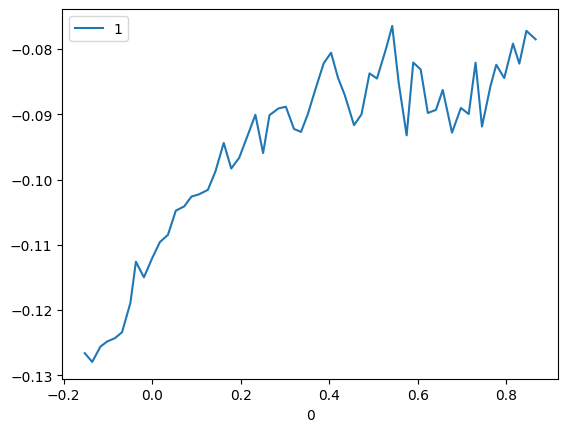

In [35]:
pd.DataFrame(invert_signature(model=model, x_vec=X_sample[0])).plot(x=0,y=1)

In [48]:
log_y = np.log(y_sample)
log_y = np.nan_to_num(log_y, nan=0.0, posinf=0.0, neginf=0.0)

dlog_y = np.diff(log_y, axis=1, prepend=log_y[:, :1])   # same shape as y_sample
dlog_y = np.nan_to_num(dlog_y, nan=0.0, posinf=0.0, neginf=0.0)

/tmp/ipykernel_2258189/2902267668.py:1: RuntimeWarning: divide by zero encountered in log
  log_y = np.log(y_sample)
/tmp/ipykernel_2258189/2902267668.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  log_y = np.log(y_sample)


In [55]:
pd.DataFrame(dlog_y[0]).head()

,0,1
0,0.000000,0.000000
1,0.000000,0.000000
2,0.000000,3.610918
3,-0.000993,4.227544
4,-0.000995,-1.043204


<Axes: xlabel='0'>

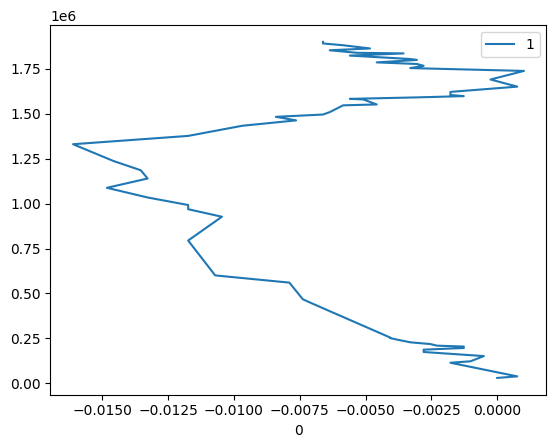

In [10]:
pd.DataFrame(y_sample[0]).cumsum().plot(x=0,y=1)